In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
print(tf.__version__)

2.3.0


In [5]:
# Dataset
imdb = keras.datasets.imdb
# 가장 많이 등장하는 상위 10,000개의 단어 사용. 
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=10000)

### 데이터 형태 확인 
 1. 텍스트는 어휘 사전의 특정 단어를 나타내는 정수로 변환되어있다. 
 2. 각 영화 리뷰들은 길이가 다르다. <- 신경망의 입력은 길이가 같아야한다! 

In [14]:
print("훈련 샘플: {}, 레이블: {}".format(len(x_train), len(y_train)))
print("데이터 샘플: ", x_train[0])
print("샘플 길이: ", len(x_train[0]), len(x_train[1]))

훈련 샘플: 25000, 레이블: 25000
데이터 샘플:  [1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]
샘플 길이:  218 189


### 정수를 단어로 다시 변환하기 
* 정수와 문자열을 매핑한 dictionary 객체에 질의하는 헬퍼(helper) 함수를 만든다.

In [33]:
# 단어와 정수 인덱스를 매핑한 딕셔너리
word_index = imdb.get_word_index()
# 처음 몇 개 인덱스는 사전에 정의되어 있다. 
print("index 갯수: ", len(word_index))
word_index["<PAD>"] = 0 
word_index["<START>"] = 1
word_index["<UNK>}"] = 2 # unknown
word_index["<UNUSED>}"] = 3 

index 갯수:  88588


In [36]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

In [50]:
def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

In [53]:
decode_review(x_train[0])

"<START> as you with out themselves powerful lets loves their becomes reaching had journalist of lot from anyone to have after out atmosphere never more room <UNK>} it so heart shows to years of every never going <UNK>} help moments or of every chest visual movie except her was several of enough more with is now current film as you of mine potentially unfortunately of you than him that with out themselves her get for was camp of you movie sometimes movie that with scary but <UNK>} to story wonderful that in seeing in character to of 70s musicians with heart had shadows they of here that with her serious to have does when from why what have critics they is you that isn't one will very to as itself with other <UNK>} in of seen over landed for anyone of <UNK>} br show's to whether from than out themselves history he name half some br of <UNK>} odd was two most of mean for 1 any an boat she he should is thought frog but of script you not while history he heart to real at barrel but when fr

### 데이터 준비
리뷰-정수 배열은 신경망에 주입하기 전에 tensor로 변환되어야한다. 변환방법?
1. one-hot encoding : 정수 배열은 0과 1로 이루어진 벡터로 변환. 그 다음 실수 벡터 데이터를 다룰 수 있는 층 (Dense 층)을 신경망의 첫 번째 층으로 사용한다. <br>
<b>num_words * num_reviews</b> 크기의 행렬이 필요하기 때문에 메모리를 많이 사용한다. 
2. padding 추가 to match the length of the array 
    <b>max_length * num_reviews</b> 크기의 정수 텐서를 만든다. 

In [54]:
# Approach2: 영화 리뷰의 길이가 같아야 하므로 pad_sequences함수를 사용하여 길이를 맞춘다. 
train_data = keras.preprocessing.sequence.pad_sequences(x_train,
                                                       value=word_index["<PAD>"],
                                                       padding='post',
                                                       maxlen=256)
test_data = keras.preprocessing.sequence.pad_sequences(x_test,
                                                       value=word_index["<PAD>"],
                                                       padding='post',
                                                       maxlen=256)

In [56]:
print(len(train_data[0]), len(train_data[1]))

256 256


### 모델 구성 
신경망은 층(layer)를 쌓아서 만든 구조. 고려해야할 2가지
1. 얼마나 많은 층을 사용할 것인가?
2. 각 층에서 얼마나 많은 hidden unit을 사용할 것인가?

In [58]:
vocab_size = 10000
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 16, input_shape=(None,)))
model.add(keras.layers.GlobalAveragePooling1D())
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 160,289
Trainable params: 160,289
Non-trainable params: 0
_________________________________________________________________


##### Hidden Units
* 입력과 출력 사이에 두 개의 중간 또는 "은닉"층이 있다. 출력의 개수는 층이 가진 표현 공간(representational space)의 차원이 된다. (학습할때 허용되는 네트워크 자유도의 양) 

* 모델에 많은 은닉유닛과 층이 있다면 네트워크는 더 복잡한 표현을 학습할 수 있다.
* 하지만 네트워크의 계산 비용이 많이 들고 원치않는 패턴을 학습할 수도 있다. 
* 훈련 데이터의 성능은 향상되지만 테스트 데이터에서는 그렇지 않은경우 : <b>Overfitting(과대적합)</b>

##### Loss function and Optimizer
* 이진 분류 문제, 모델이 확률을 출력(출력층의 유닛이 하나이고 sigmoid 활성화 함수 사용됨) 이므로 binary_crossentropy 손실 함수를 사용한다. 
    - 확률 분포 간의 거리를 측정한다. 정답과 예측 분포 사이의 거리 
* mean_squared_error도 사용가능. 

cf) Regression문제(주택가격 예측문제)일때는 mean squared error(평균 제곱 오차)를 사용한다

In [59]:
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])

##### Validation Set
* 모델을 훈련할 때 모델이 만난 적 없는 데이터에서 정확도를 확인하는 것이 좋다. 

In [63]:
x_val = train_data[:10000]
partial_x_train = train_data[10000:]

y_val = y_train[:10000]
partial_y_train = y_train[10000:]

##### Training
* 이 모델을 512개의 샘플로 이루어진 mini-batch에서 40번의 epoch동안 훈련한다. x_train, y_train Tensor에 있는 모든 샘플에 대해 40번 반복한다는 뜻. 

* verbose = verbosity mode (0:silent, 1:progress bar, 2:one line per epoch) 얼마나 자세하게 정보를 표시할 것인가를 지정

In [65]:
history = model.fit(partial_x_train,
                   partial_y_train, 
                   epochs=40,
                   batch_size=512,
                   validation_data=(x_val,y_val),
                   verbose=1)

Epoch 1/40
30/30 [==============================] - 0s 16ms/step - loss: 0.6926 - accuracy: 0.5607 - val_loss: 0.6916 - val_accuracy: 0.6583
Epoch 2/40
30/30 [==============================] - 0s 11ms/step - loss: 0.6894 - accuracy: 0.7219 - val_loss: 0.6868 - val_accuracy: 0.7242
Epoch 3/40
30/30 [==============================] - 0s 11ms/step - loss: 0.6811 - accuracy: 0.7267 - val_loss: 0.6751 - val_accuracy: 0.6967
Epoch 4/40
30/30 [==============================] - 0s 11ms/step - loss: 0.6631 - accuracy: 0.7542 - val_loss: 0.6526 - val_accuracy: 0.7457
Epoch 5/40
30/30 [==============================] - 0s 11ms/step - loss: 0.6324 - accuracy: 0.7779 - val_loss: 0.6188 - val_accuracy: 0.7745
Epoch 6/40
30/30 [==============================] - 0s 11ms/step - loss: 0.5904 - accuracy: 0.7985 - val_loss: 0.5766 - val_accuracy: 0.7837
Epoch 7/40
30/30 [==============================] - 0s 11ms/step - loss: 0.5414 - accuracy: 0.8179 - val_loss: 0.5302 - val_accuracy: 0.8100
Epoch 8/40
30

##### Evaluation

In [67]:
results = model.evaluate(test_data, y_test, verbose=2)
results2 = model.evaluate(test_data, y_test, verbose=1)
print(results)
print(results2)

782/782 - 0s - loss: 0.3343 - accuracy: 0.8719
782/782 [==============================] - 0s 551us/step - loss: 0.3343 - accuracy: 0.8719
[0.33434998989105225, 0.8718799948692322]
[0.33434998989105225, 0.8718799948692322]


##### 정확도와 손실 그래프 그리기 

In [68]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [72]:
# !pip install matplotlib
import matplotlib.pyplot as plt

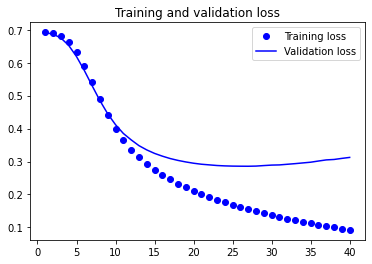

In [74]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epoch = range(1, len(acc) + 1)

plt.plot(epoch, loss, 'bo', label='Training loss')
plt.plot(epoch, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel
plt.ylabel
plt.legend() # 자동기능을 이용한 작성

plt.show()

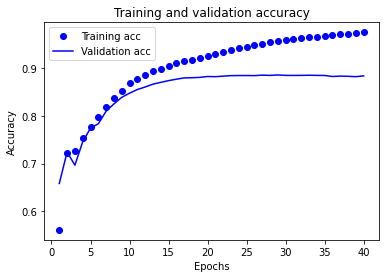

In [76]:
plt.clf() # Clear Figure

plt.plot(epoch, acc, 'bo', label='Training acc')
plt.plot(epoch, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()